In [15]:
import re
import numpy as np
import glob
import os

In [ ]:
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

In [19]:
def parse_timings_from_file(filename):
    """Extract timing values from one file."""
    timings = []
    with open(filename, "r") as f:
        for line in f:
            # match lines like "time total: 135.405116"
            match = re.search(r"time .*?:\s+([\d\.Ee+-]+)", line)
            if match:
                timings.append(float(match.group(1)))
    return timings


def collect_data(folder = ""):
    # find files named like output${threads}P${P}
    files = glob.glob(folder + "output*P*")

    threads_list = []
    all_timings = []

    for fname in files:
        # extract thread number from filename (between "output" and "P")
        match = re.search(r"outputT(\d+)P", fname)
        if not match:
            continue
        threads = int(match.group(1))

        timings = parse_timings_from_file(fname)

        threads_list.append(threads)
        all_timings.append(timings)

    array_T = np.array(threads_list)
    array_time = np.array(all_timings)

    return array_T, array_time



array_T, array_time = collect_data("Orfeo/OpenMP/")
array_T

array([ 2,  4, 32,  1, 16,  8, 64])

In [32]:
idx = np.argsort(array_T)
array_T[idx]

array([ 1,  2,  4,  8, 16, 32, 64])

In [24]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter



plt.style.use('default') 
# Set the ultra-minimal style
plt.rcParams.update({
    'figure.facecolor': 'None',
    'axes.facecolor': 'None',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.5,

    # remove borders
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,

    # ticks
    'xtick.color': 'lightgray',
    'ytick.color': 'lightgray',
    'xtick.direction': 'out',
    'ytick.direction': 'out',

    # grid
    'axes.grid': True,          # enable grid globally
    'grid.color': '#777777',  # very light gray
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,

    # lines
    'lines.linewidth': 1.0,

    # font
    'font.size': 10,
    'font.family': 'sans-serif',
    'text.color': 'gray',   # axis labels, titles, etc.
    'axes.labelcolor': 'gray',
})


In [ ]:
def plotTime(x, times, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx]

    serial = times[0, 0] if serial is None else serial
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  times[:, 0], color = "#E2B1FF")

    x_ideal = np.linspace(x[0], x[-1], 200)
    ax.plot(x_ideal, serial/x_ideal, linestyle = "--", color = "#FFA0D4")

    ax.set_xscale("log")
    ax.set_xticks(x )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())


    ax.set_xlabel(x_label)
    ax.set_ylabel("Time (s)")
    plt.show()
    

In [65]:
def speedUp(x, times, serial = None, x_label = "Threads"):
    idx = np.argsort(x)
    x = x[idx]
    times = times[idx]

    serial = times[0, 0] if serial is None else serial
    
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(x,  serial/times[:, 0], color = "#E2B1FF")

    x_ideal = np.linspace(x[0], x[-1], 200)
    ax.plot(x_ideal, x_ideal, linestyle = "--", color = "#FFA0D4")

    ax.set_xticks(x )


    ax.set_xlabel(x_label)
    ax.set_ylabel("Speed up")
    plt.show()

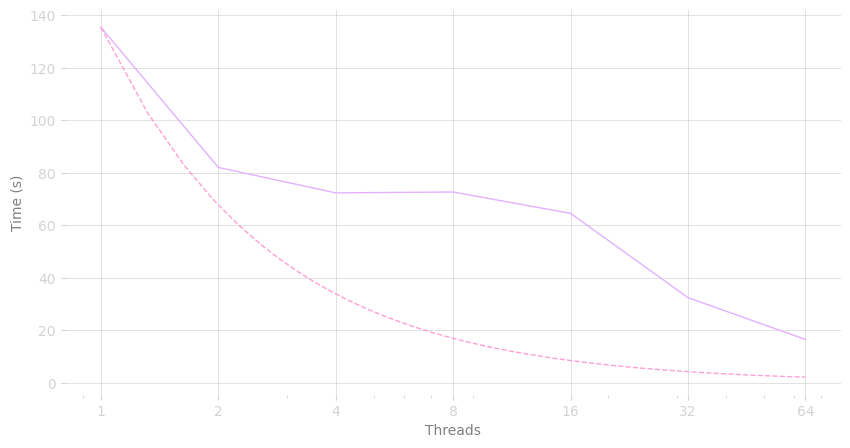

In [60]:
plotTime(array_T, array_time)

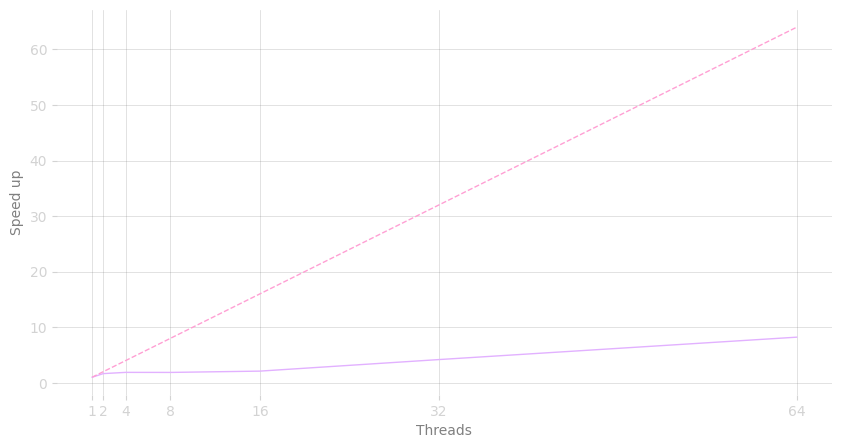

In [66]:
speedUp(array_T, array_time)

In [ ]:
def percentagesPlot(cpus, times, serial_t, x_label = "Threads"):
    idx = np.argsort(cpus)
    timeTot = timesPercentage = times[idx][:, 1:-1].sum(axis=-1)
    timesPercentage = times[idx][:, 1:-1]/timeTot[:,None]
    cpus  = cpus[idx]

    rowLabels = np.array(["Fill Buffers", 
                          "Update center",
                          "wait EAST WEST",
                          "compute EAST WEST",
                          "wait NORTH SOUTH",
                          "compute NORTH SOUTH"])

    colors = np.array([ "#F2FF00", 
                        "#86FF76",
                        "#8F9FFF",
                        "#0026FF",
                        "#FF8989",
                        "#FF0000"])

    fig, ax = plt.subplots(figsize = (10, 5))
    n_rows, n_cols = timesPercentage.shape
    cumulative = np.zeros(n_rows)

    for j in range(n_cols):
        ax.bar(range(n_rows), timesPercentage[:, j], bottom=cumulative, color=colors[j], label=rowLabels[j])
        cumulative += timesPercentage[:, j]


    ax.set_title('Time Percentages')
    ax.set_xticks(range(n_rows))
    ax.set_xticklabels([cpu for cpu in cpus])

    ax.set_ylabel("Time %")
    ax.set_xlabel(x_label)
    plt.show()

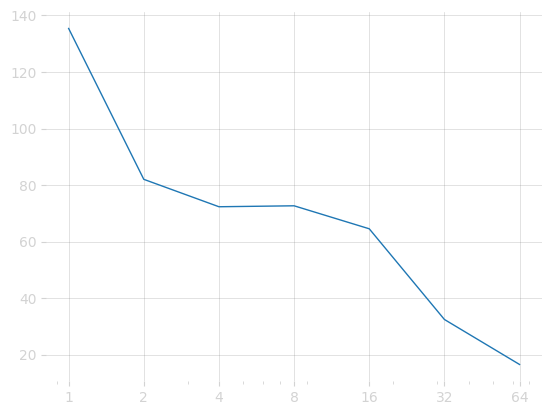

In [25]:
fig, ax = plt.subplots()

ax.plot(array_T[idx], array_time[idx][:, 0])
ax.set_xscale("log")
ax.set_xticks(array_T[idx])
ax.get_xaxis().set_major_formatter(ScalarFormatter())

plt.show()